# Curve v2 newton method

The comparison of newton‘s method implementations.

In [8]:
from functools import reduce
import pandas as pd
import sympy as sym

In [9]:
n = 2
rates = [10**18, 10**18, 10**18]

MAX_TIMES = 255
A_MULTIPLIER = 10000
INIT_PRICE = [10**18, 3000*10**18]   # USDC-ETH


In [10]:
def D_sym(_A, _gamma, xp):
    '''calculate theoretical value by sympy'''
    x, y = sym.symbols('x y', positive=True, real=True)
    D, A, k, k0, gamma = sym.symbols(
        'D A k k0 gamma', positive=True, real=True)

    A = _A
    x = xp[0]
    y = xp[1]
    gamma = _gamma

    k0 = 4*(x*y)/(D**2)
    k = A*k0*gamma**2/(gamma+1-k0)**2
    expr = k*D*(x+y)+x*y-k*D**2-(D/2)**2
    s_expr = sym.solve(expr, D)
    d = s_expr[-1].evalf()

    return int(d*1e18)


In [11]:
def geometric_mean(x):
    N = len(x)
    x = sorted(x, reverse=True)  # Presort - good for convergence
    D = x[0]
    for i in range(255):
        D_prev = D
        tmp = 10 ** 18
        for _x in x:
            tmp = tmp * _x // D
        D = D * ((N - 1) * 10**18 + tmp) // (N * 10**18)
        diff = abs(D - D_prev)
        if diff <= 1 or diff * 10**18 < D:
            return D
    raise ValueError("Did not converge")


def D_curve(A, gamma, x, target_value):
    D = len(x) * geometric_mean(x)
    i = 0

    S = sum(x)
    x = sorted(x, reverse=True)
    N = len(x)
    
    losses = []

    for i in range(255):
        D_prev = D

        K0 = 10**18
        for _x in x:
            K0 = K0 * _x * N // D

        _g1k0 = abs(gamma + 10**18 - K0)

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1 = 10**18 * D // gamma * _g1k0 // gamma * _g1k0 * A_MULTIPLIER // A

        # 2*N*K0 / _g1k0
        mul2 = (2 * 10**18) * N * K0 // _g1k0

        neg_fprime = (S + S * mul2 // 10**18) + mul1 * N // K0 - mul2 * D // 10**18
        assert neg_fprime > 0  # Python only: -f' > 0

        # D -= f / fprime
        D = (D * neg_fprime + D * S - D**2) // neg_fprime - D * (mul1 // neg_fprime) // 10**18 * (10**18 - K0) // K0

        losses.append(abs(D - target_value))

        if D < 0:
            D = -D // 2
        if abs(D - D_prev) <= max(100, D // 10**14):
            return D, losses

    raise ValueError("Did not converge")


def D_complete(xp, A, target_value, optimized=False):
    '''complete formula, neither simplified nor optimized'''
    Dprev = 0
    S = sum(xp)
    D = S  # v1 initial value

    Ann = A * n

    losses = []

    while abs(D - Dprev) > 1:
        # D[j]**(n+1) / (n**n prod(x_i)))
        D_P = D
        for x in xp:
            D_P = D_P * D // (n * x)

        Dprev = D

        if optimized:
            # optimized algorithm, division operation must be performed last
            denominator = D*(1 - Ann) - (n+1)*D_P
            numerator = D*(Ann * S + D - Ann*D - D_P)
            D = (D*denominator - numerator) // denominator
        else:
            # not optimized
            denominator = 1 - Ann - (n+1)*(D_P//D)
            numerator = (Ann * S + D - Ann*D - D_P)
            D = D - numerator // denominator


        losses.append(abs(D - target_value))

        if len(losses) >= MAX_TIMES:
            break

    return D, losses


def process_newton_D(A, gamma, xp, target_value):
    return D_curve(A, gamma, xp, target_value), (0, [0])
    # return D_curve(xp, A, target_value), D_complete(xp, A, target_value, optimized=False)


In [12]:
def compare(A_list, xp_list):
    '''compare different newton‘s method implementations'''

    data = []
    losses = []

    for A in A_list:
        for xp in xp_list:
            xp_decimals = [xp*10**18 for xp in xp]

            gamma = int(0.1 * 1e18)

            # base on sympy result to calc loss
            d_sym = D_sym(A, 0.1, xp)
            (d_curve, d_curve_losses), (d_complete,
                                        d_complete_losses) = process_newton_D(A*n**n*A_MULTIPLIER, gamma, xp_decimals, d_sym)
            curve_loss = abs(d_curve - d_sym)
            complete_loss = abs(d_complete - d_sym)

            data.append([A, "{:.3f}".format(xp[0]), "{:.3f}".format(xp[1]), d_sym,
                        d_curve, len(d_curve_losses), curve_loss,
                        # d_complete, len(d_complete_losses), complete_loss
                        ])

            losses.append([d_curve_losses, d_complete_losses])

    # loss: loss ratia * 1e18
    df = pd.DataFrame(data, columns=[
                      'A', 'x', 'y', 'd_sym', 'd_curve', 'times', 'loss',
                    #   'd_complete', 'times', 'loss'
                      ])
    return df, losses


In [13]:
'''
print results
'''
pd.set_option('display.width', 5000)
pd.set_option('display.float_format', lambda x: '%d' % x)

A_list = [100]
xp_list = [[10, 90], [49, 51]]

comparison, losses = compare(A_list, xp_list)
print(comparison)


     A       x       y                 d_sym               d_curve  times   loss
0  100  10.000  90.000  88933775303735738368  88933775303735775782     12  37414
1  100  49.000  51.000  99999899668056096768  99999899668056097109      4    341


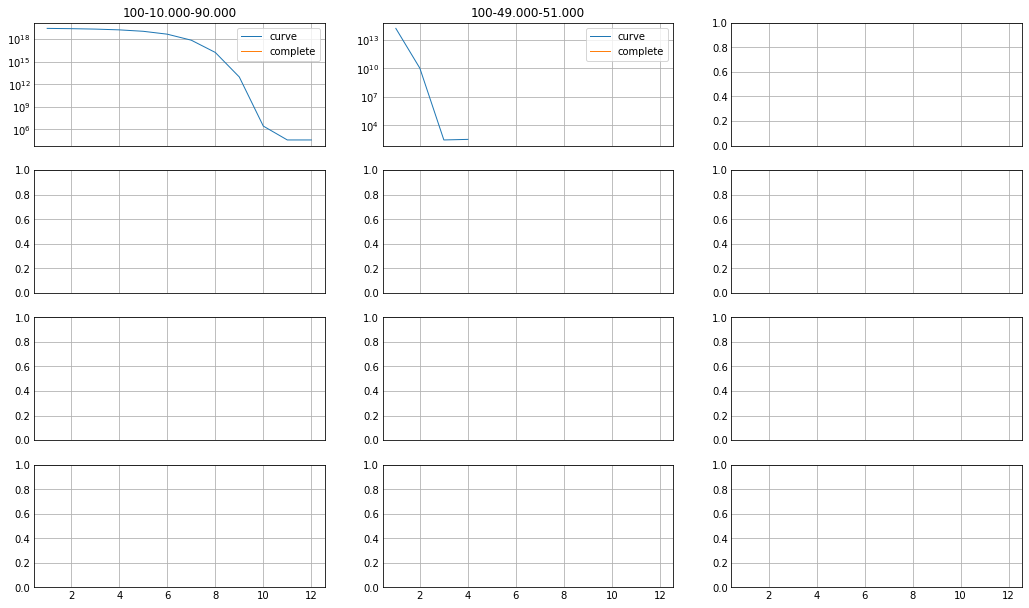

In [14]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')


# plot
n_rows = 4
n_cols = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True,
                        figsize=(14, 8))
# fig.suptitle("newton's method loss comparision")


def draw_loss(ax_index, curve_losses, complete_losses):
    _ax = axs[ax_index // n_cols][ax_index % n_cols]

    x_max = max(len(curve_losses), len(complete_losses))

    x = [i+1 for i in range(x_max)]  # axis-x is loop times

    y0 = []
    y1 = []
    for j in range(x_max):
        if j < len(curve_losses):
            y0.append(curve_losses[j])
        else:
            y0.append(None)
        if j < len(complete_losses):
            y1.append(complete_losses[j])
        else:
            y1.append(None)
    l = comparison.loc[ax_index]
    _ax.set_yscale('log')
    _ax.plot(x, y0, linewidth=1.0, label="curve")
    _ax.plot(x, y1, linewidth=1.0, label="complete")
    _ax.set_title("{}-{}-{}".format(l['A'], l['x'], l['y']))
    _ax.legend(loc='best')

for i in range(len(losses)):
    draw_loss(i, losses[i][0], losses[i][1])


plt.show()
